### Connect to Drive

### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [4]:
dataset = pd.read_csv('AirQuality.csv')
print(dataset.shape)
dataset.head()

(43800, 3)


,dew,temperature,pression
0,-16,-4.0,1020.0
1,-15,-4.0,1020.0
2,-11,-5.0,1021.0
3,-7,-5.0,1022.0
4,-7,-5.0,1022.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  int64  
 1   temperature  43800 non-null  float64
 2   pression     43800 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.0 MB


In [6]:
dataset['dew'] = dataset['dew'].astype(np.float32)
dataset['temperature'] = dataset['temperature'].astype(np.float32)
dataset['pression'] = dataset['pression'].astype(np.float32)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  float32
 1   temperature  43800 non-null  float32
 2   pression     43800 non-null  float32
dtypes: float32(3)
memory usage: 513.4 KB


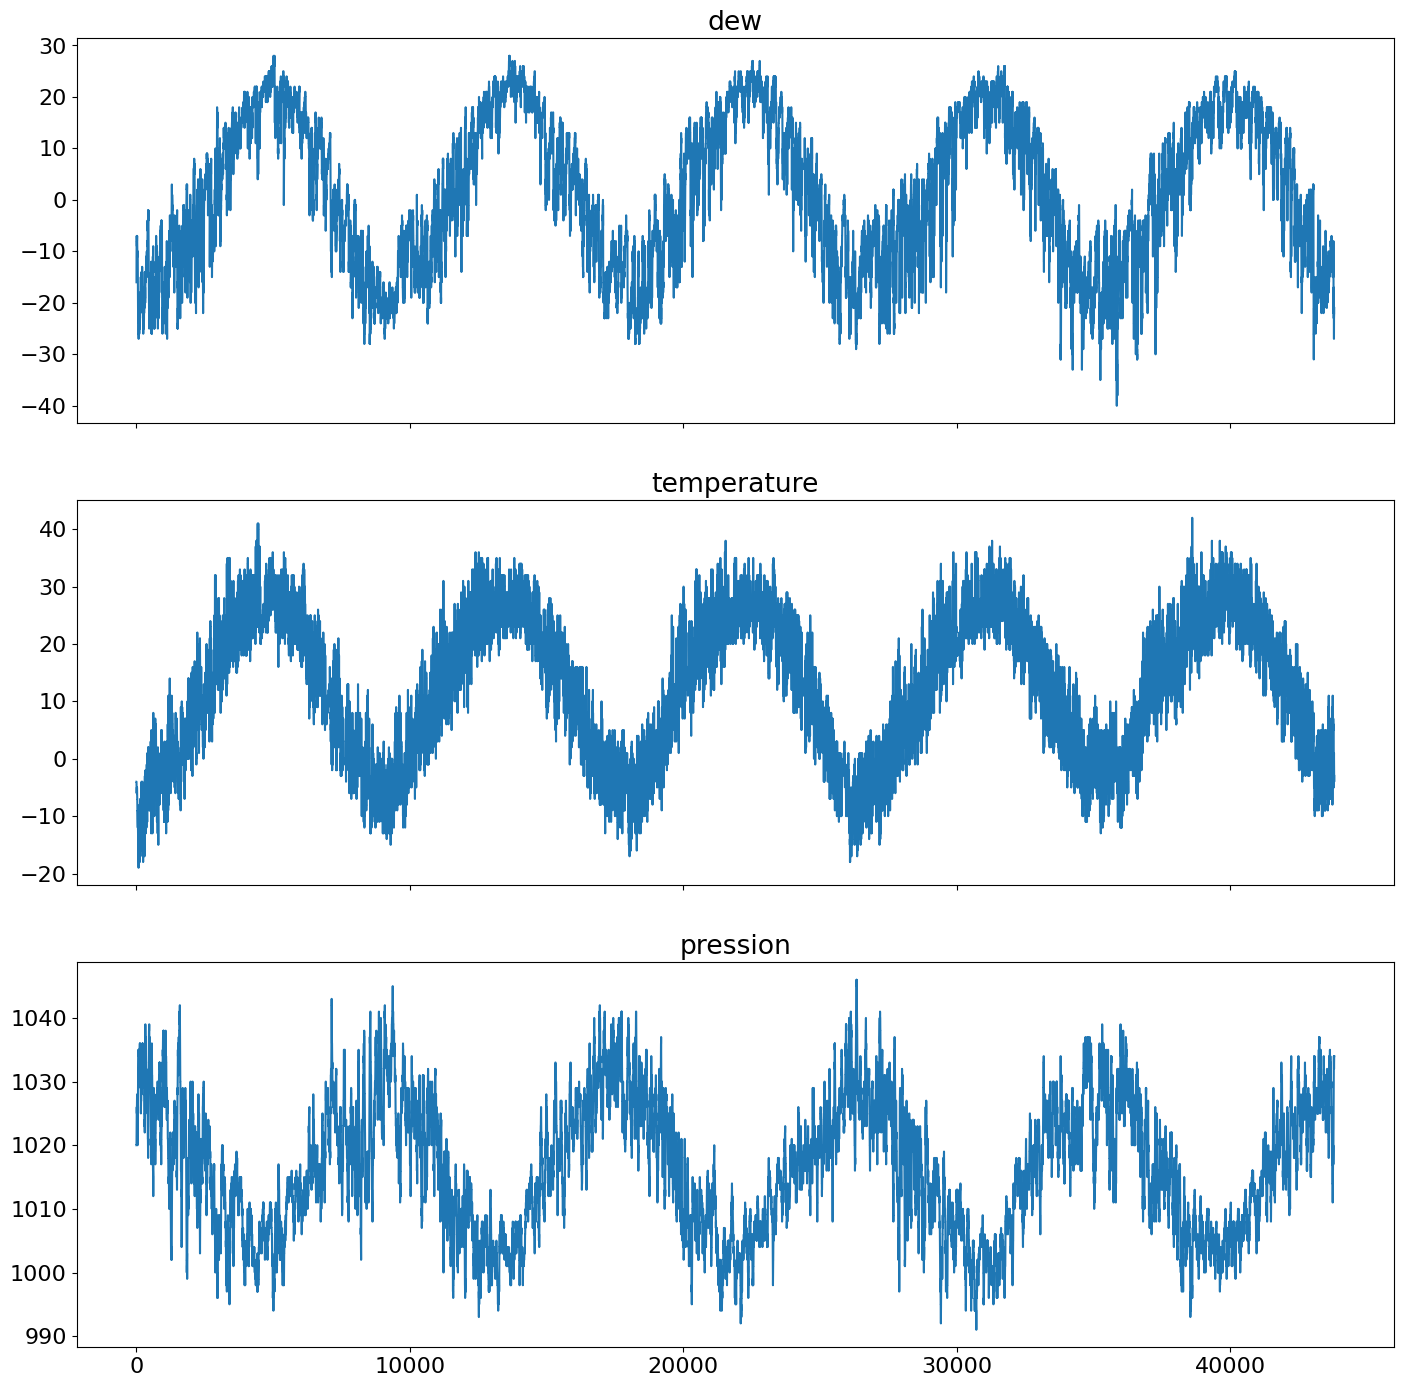

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(40000, 3) (3800, 3)


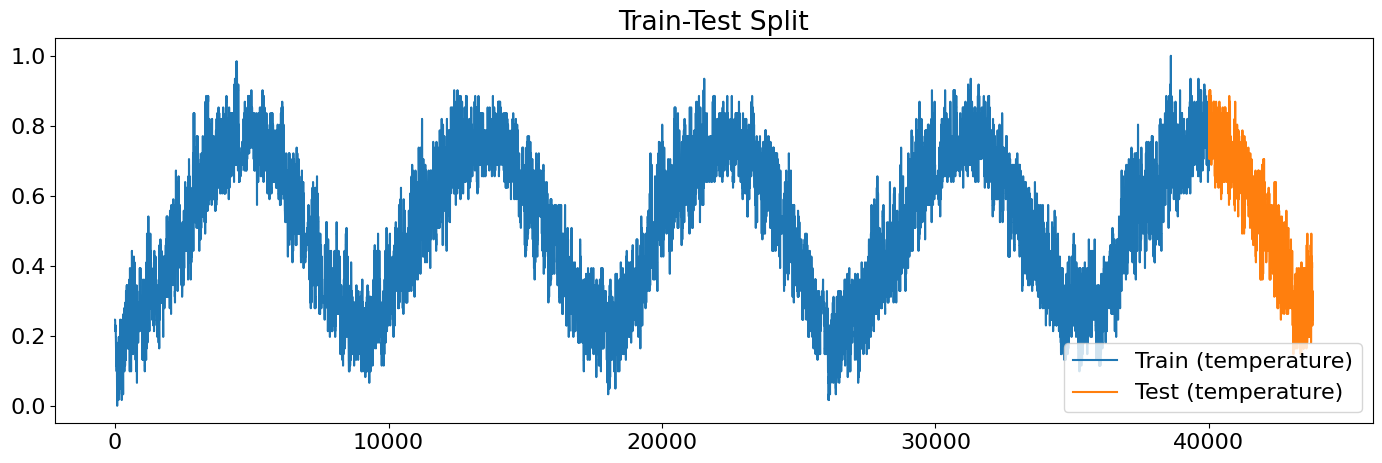

In [8]:
test_size = 3800
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.temperature, label='Train (temperature)')
plt.plot(X_test_raw.temperature, label='Test (temperature)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
window = 100
stride = 5

In [10]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 100, 3)

In [11]:
def build_sequences(df, target_labels=['temperature'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
target_labels = dataset.columns
telescope = 50

### Multivariate Forecating (Direct)

In [13]:
direct_telescope = telescope

In [14]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, direct_telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7970, 100, 3), (7970, 50, 3), (730, 100, 3), (730, 50, 3))

In [15]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

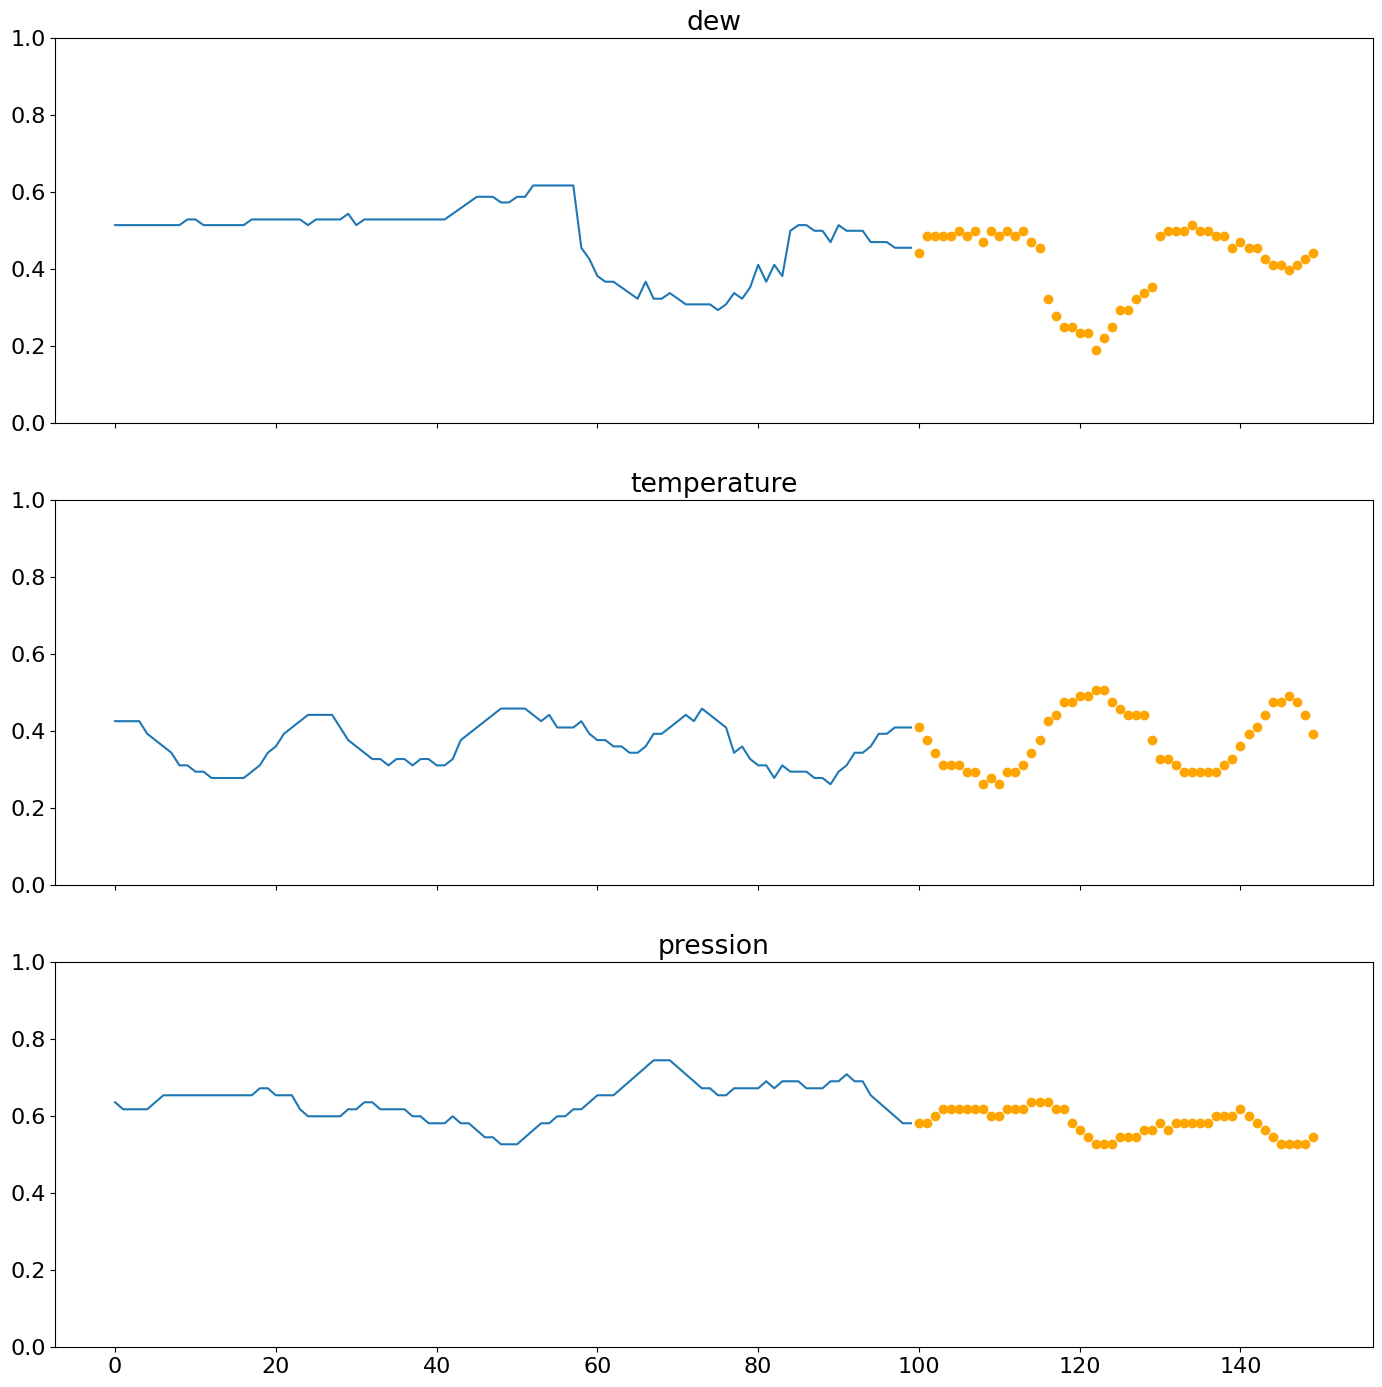

In [16]:
inspect_multivariate(X_train, y_train, target_labels, direct_telescope)

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [18]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 3)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 128)          34816     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 100, 3)            1155      
                                                                 
 cropping (Cropping1D)       (None, 50, 3)             0         
                                                                 
Total params: 85251 (333.01 KB)
Trainable params: 85251 (333.01 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

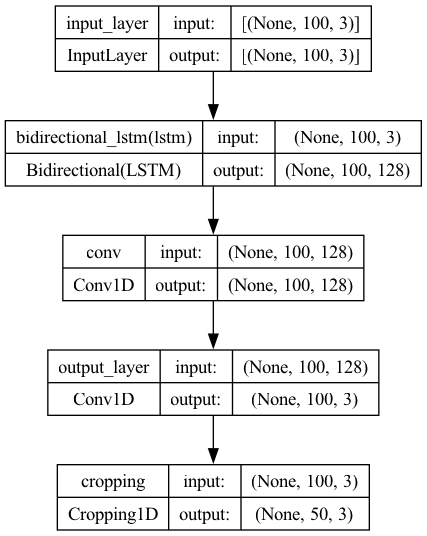

In [19]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
113/113 [==============================] - 11s 51ms/step - loss: 0.0208 - val_loss: 0.0108 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - 4s 38ms/step - loss: 0.0091 - val_loss: 0.0079 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - 5s 43ms/step - loss: 0.0087 - val_loss: 0.0075 - lr: 0.0010
Epoch 4/200
113/113 [==============================] - 4s 38ms/step - loss: 0.0085 - val_loss: 0.0091 - lr: 0.0010
Epoch 5/200
113/113 [==============================] - 4s 31ms/step - loss: 0.0086 - val_loss: 0.0092 - lr: 0.0010
Epoch 6/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0085 - val_loss: 0.0101 - lr: 0.0010
Epoch 7/200
113/113 [==============================] - 3s 29ms/step - loss: 0.0084 - val_loss: 0.0077 - lr: 0.0010
Epoch 8/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0080 - val_loss: 0.0084 - lr: 0.0010
Epoch 9/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0

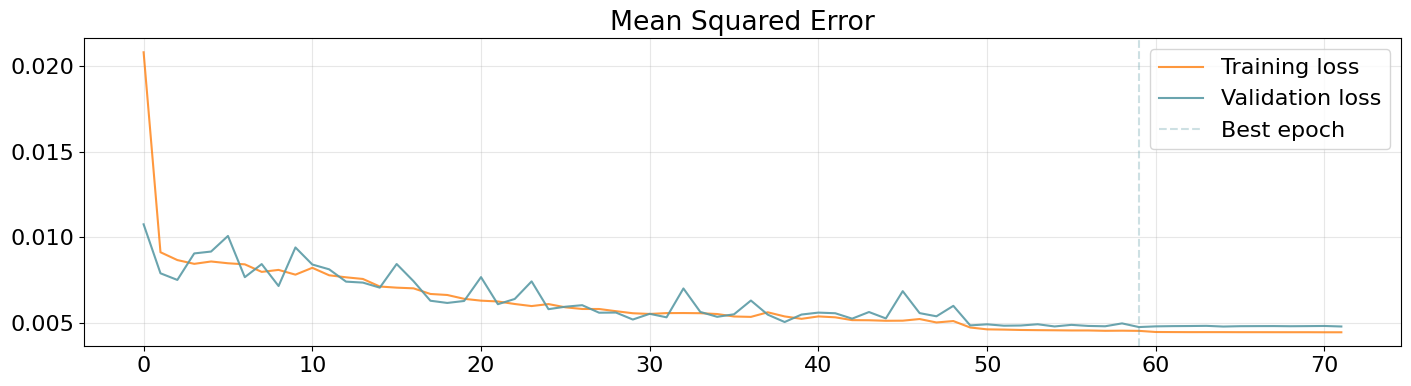

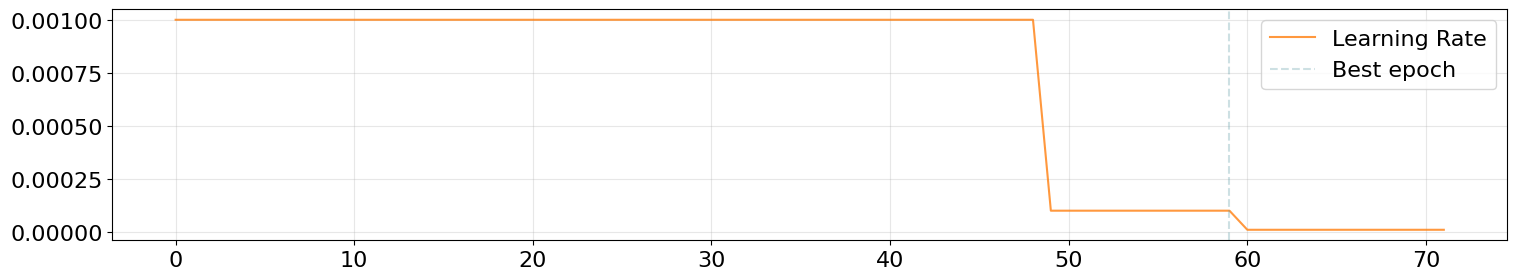

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
# model.save('DirectForecasting')
model = tfk.models.load_model('DirectForecasting')

Test evaluation

In [23]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (730, 50, 3)
Mean Squared Error: 0.004172882065176964
Mean Absolute Error: 0.04791022837162018


In [24]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

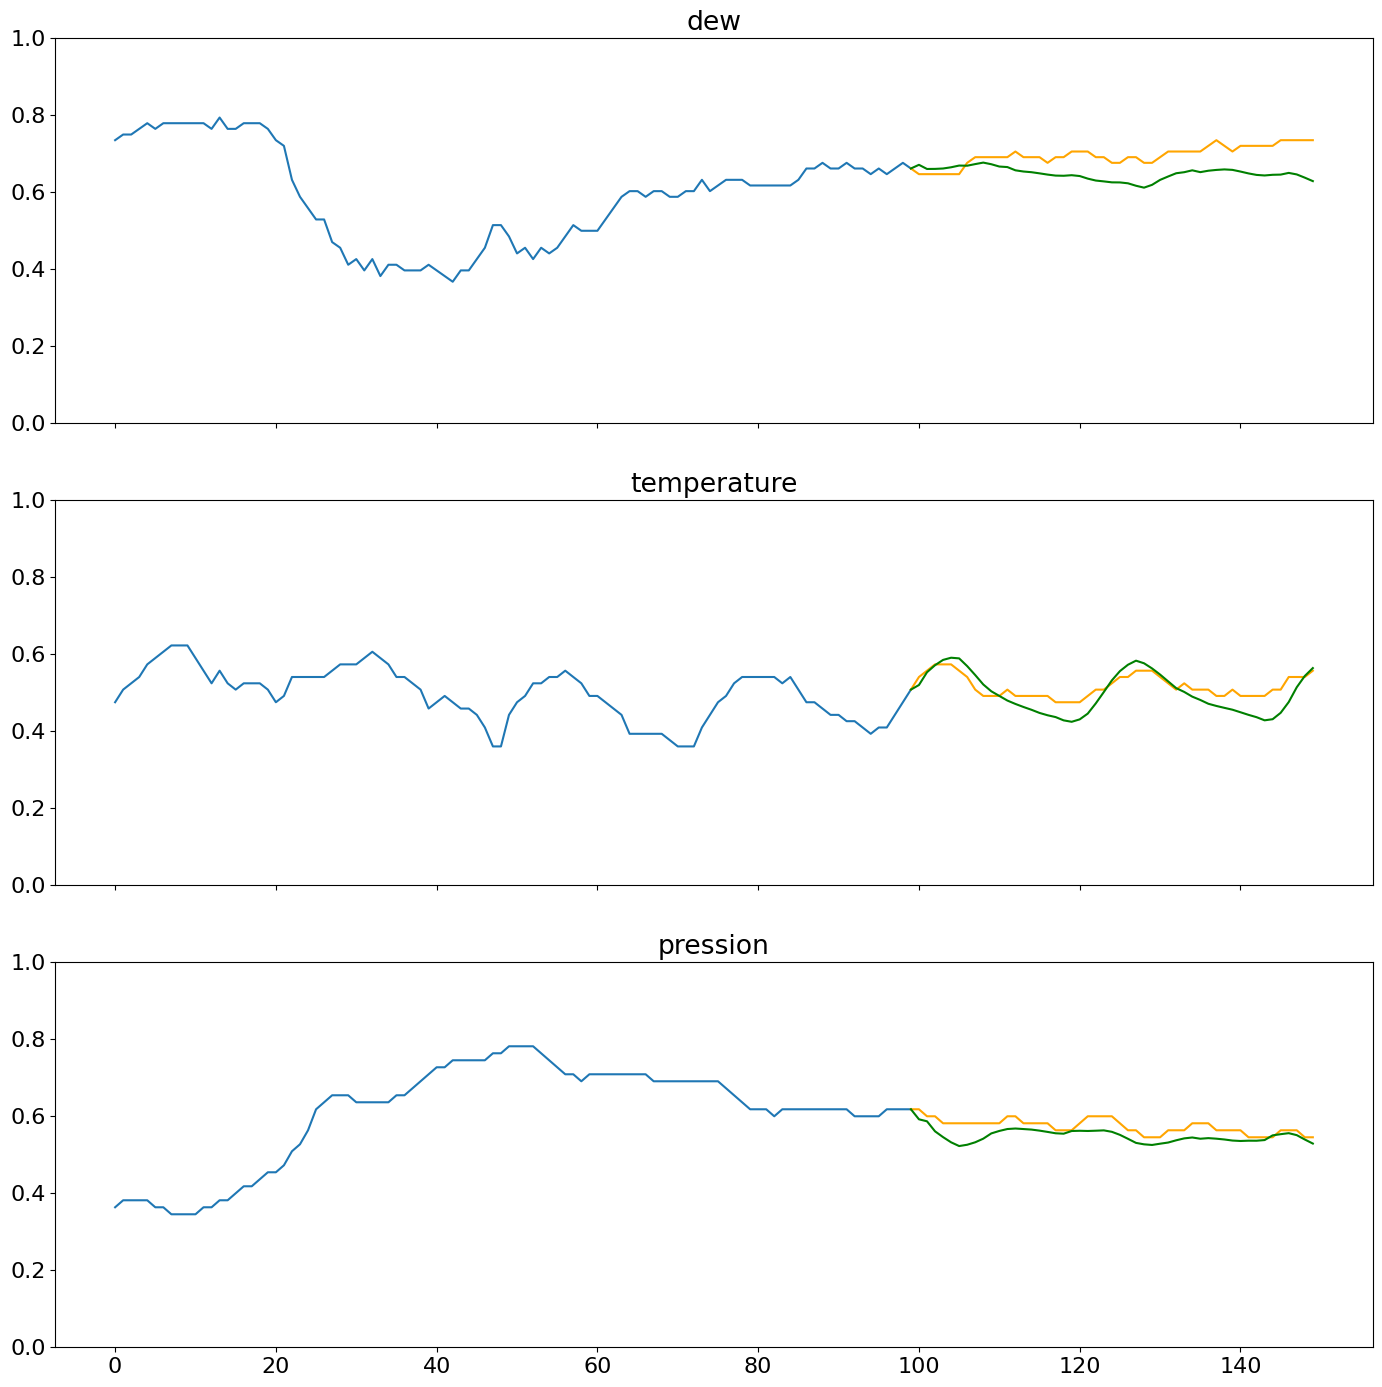

In [25]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, direct_telescope)

Predict the future

In [26]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [27]:
future_predictions = model.predict(future,verbose=0)
future_predictions = np.concatenate([np.expand_dims(future[:,-1,:],axis=0),future_predictions],axis=1)
maes = np.concatenate([np.array([[0,0,0]]),maes],axis=0)

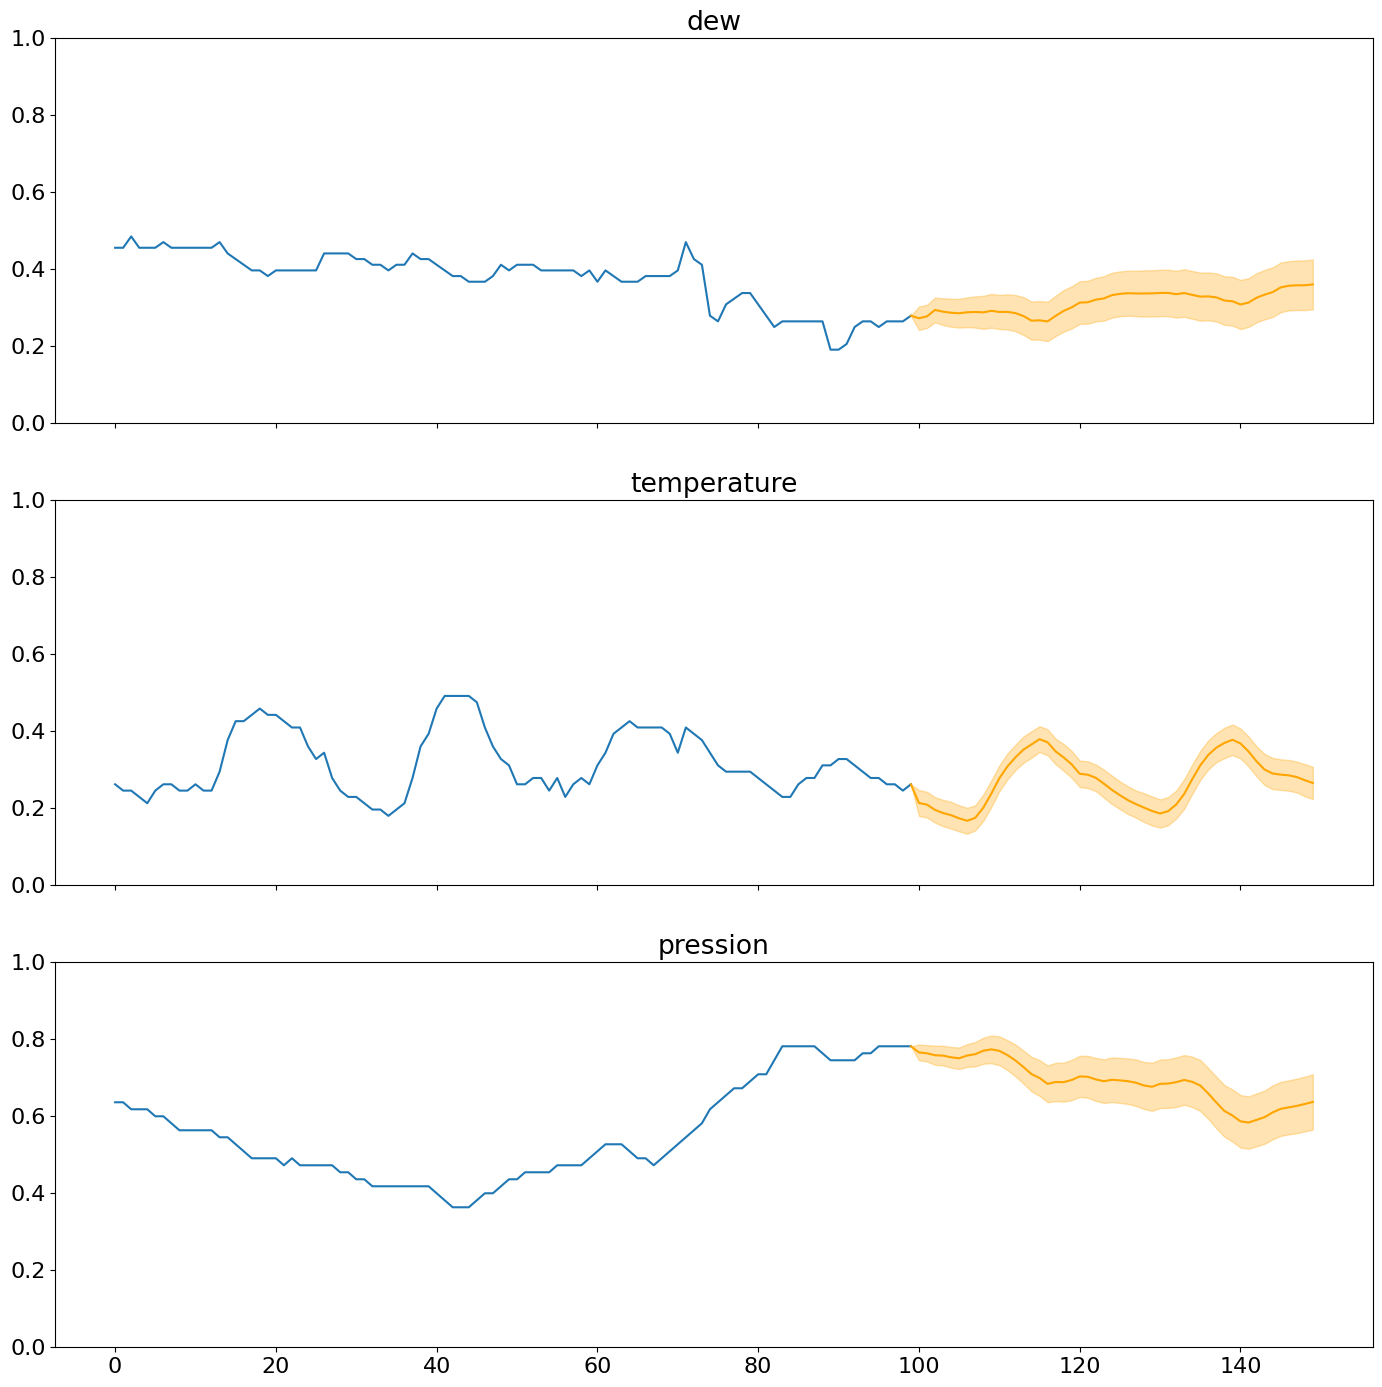

In [28]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i])-1, len(future[0,:,i])+direct_telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i])-1, len(future[0,:,i])+direct_telescope),
        future_predictions[0,:,i]+maes[:,i],
        future_predictions[0,:,i]-maes[:,i],
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

### Multivariate Forecasting (Autoregression)

In [29]:
autoregressive_telescope = 10
assert autoregressive_telescope < telescope

In [30]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, autoregressive_telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, autoregressive_telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7978, 100, 3), (7978, 10, 3), (738, 100, 3), (738, 10, 3))

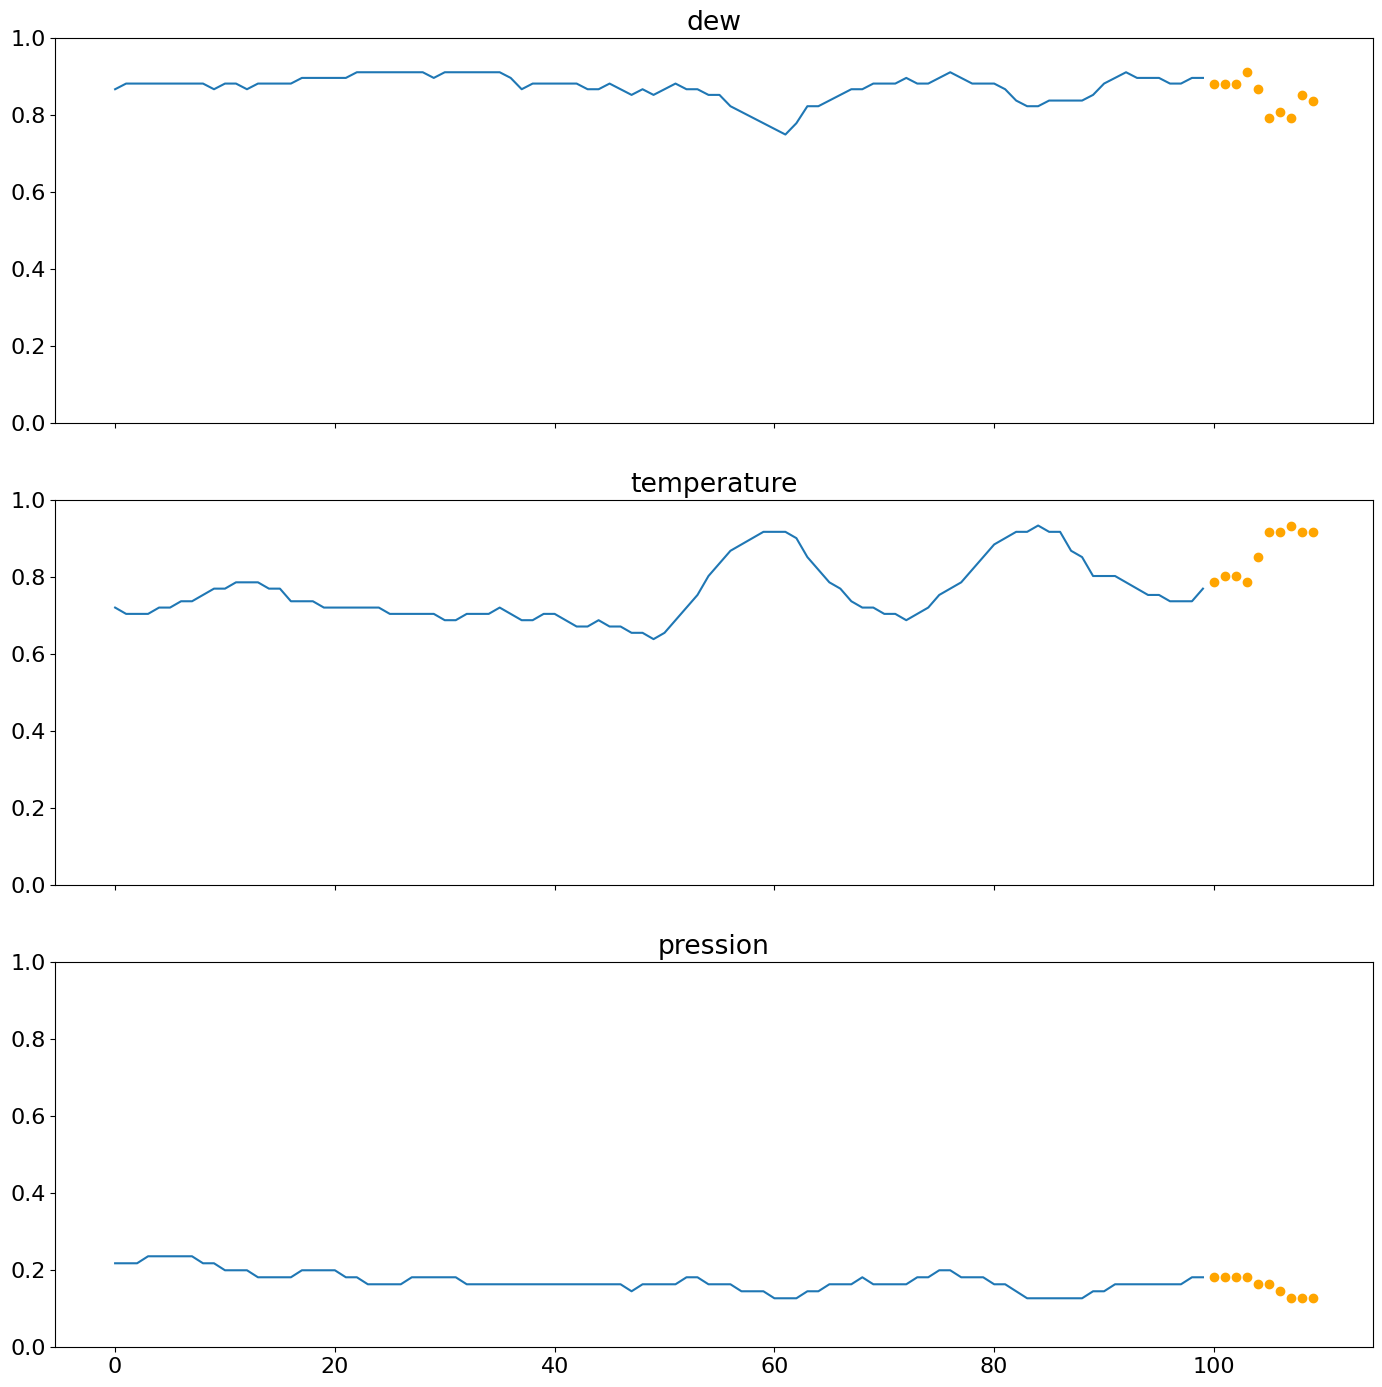

In [31]:
inspect_multivariate(X_train, y_train, target_labels, autoregressive_telescope)

In [32]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 3)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 128)          34816     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 100, 3)            1155      
                                                                 
 cropping (Cropping1D)       (None, 10, 3)             0         
                                                                 
Total params: 85251 (333.01 KB)
Trainable params: 85251 (333.01 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

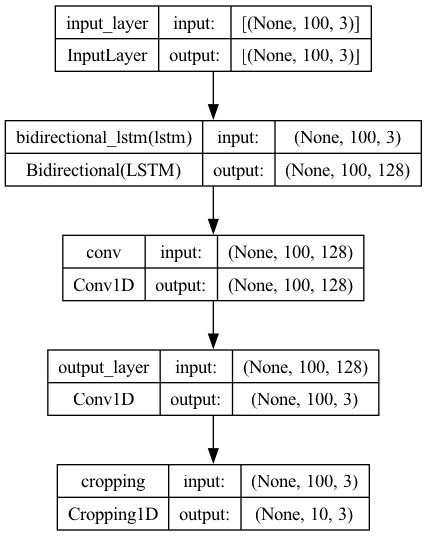

In [33]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [34]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
113/113 [==============================] - 6s 40ms/step - loss: 0.0206 - val_loss: 0.0091 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - 3s 31ms/step - loss: 0.0094 - val_loss: 0.0083 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - 4s 32ms/step - loss: 0.0089 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0088 - val_loss: 0.0081 - lr: 0.0010
Epoch 5/200
113/113 [==============================] - 3s 31ms/step - loss: 0.0081 - val_loss: 0.0075 - lr: 0.0010
Epoch 6/200
113/113 [==============================] - 4s 31ms/step - loss: 0.0079 - val_loss: 0.0072 - lr: 0.0010
Epoch 7/200
113/113 [==============================] - 3s 31ms/step - loss: 0.0076 - val_loss: 0.0070 - lr: 0.0010
Epoch 8/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0074 - val_loss: 0.0066 - lr: 0.0010
Epoch 9/200
113/113 [==============================] - 3s 29ms/step - loss: 0.00

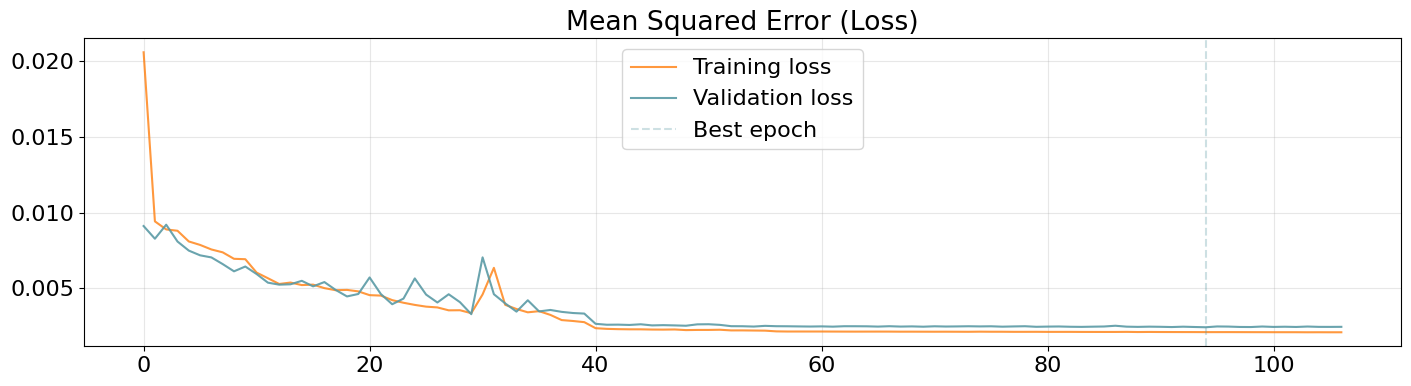

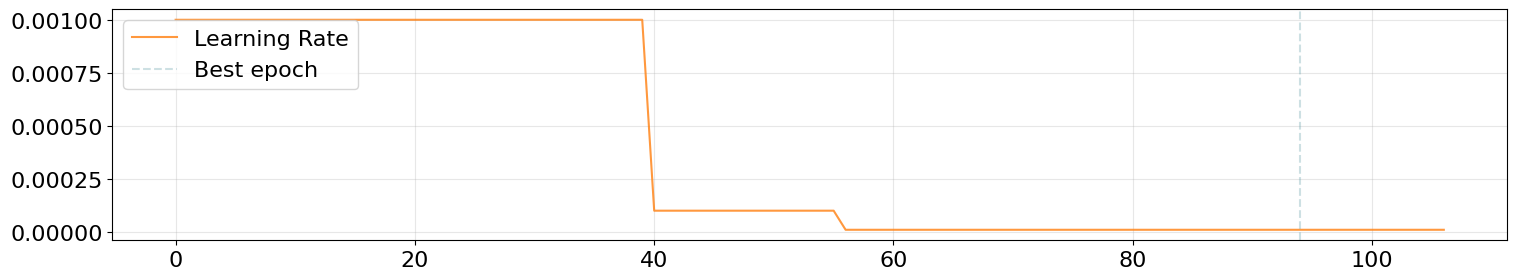

In [35]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [36]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressiveForecasting')

In [37]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (738, 10, 3)
Mean Squared Error: 0.001595606910996139
Mean Absolute Error: 0.02910802513360977


In [38]:
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_test_reg.shape, y_test_reg.shape

((730, 100, 3), (730, 50, 3))

In [39]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,telescope,autoregressive_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1)

In [40]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (730, 50, 3)
Mean Squared Error: 0.004505110904574394
Mean Absolute Error: 0.048325065523386


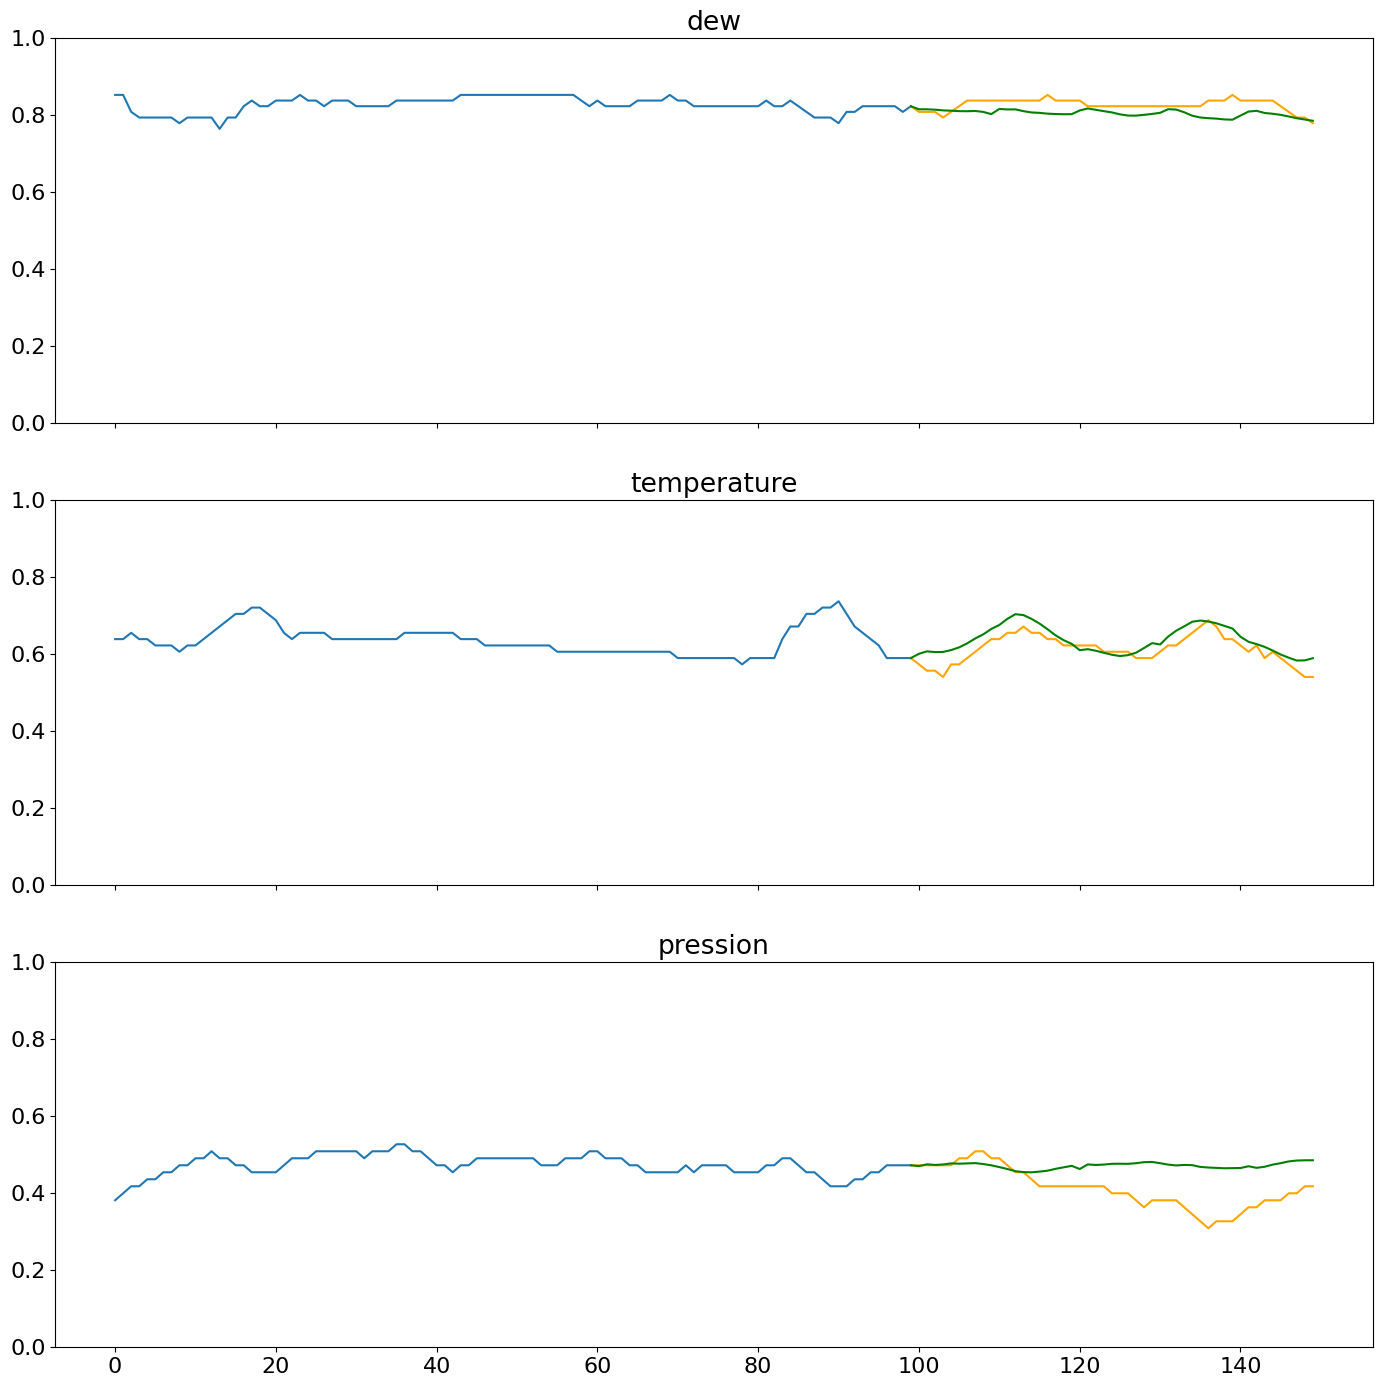

In [41]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, telescope)

predict the future

In [42]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [43]:
# Autoregressive Forecasting (Future)
reg_future = np.array([])
X_temp = future # The sequence to forecast
for reg in range(0,telescope,autoregressive_telescope): # For each telescope step (i.e., reg_telescope%telescope is preferred to be 0)
    pred_temp = model.predict(X_temp,verbose=0) # Predict the current sequence
    if(len(reg_future)==0):
        reg_future = pred_temp # Initialize the forecasting
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1) # Append the prediction to the whole forecasting
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1) # Shift the input of the next predict so that the just predicted sequence is at the end of the input, and the dimention is correct

In [44]:
reg_future = np.concatenate([np.expand_dims(future[:,-1,:],axis=0),reg_future],axis=1)
maes = np.concatenate([np.array([[0,0,0]]),maes],axis=0)

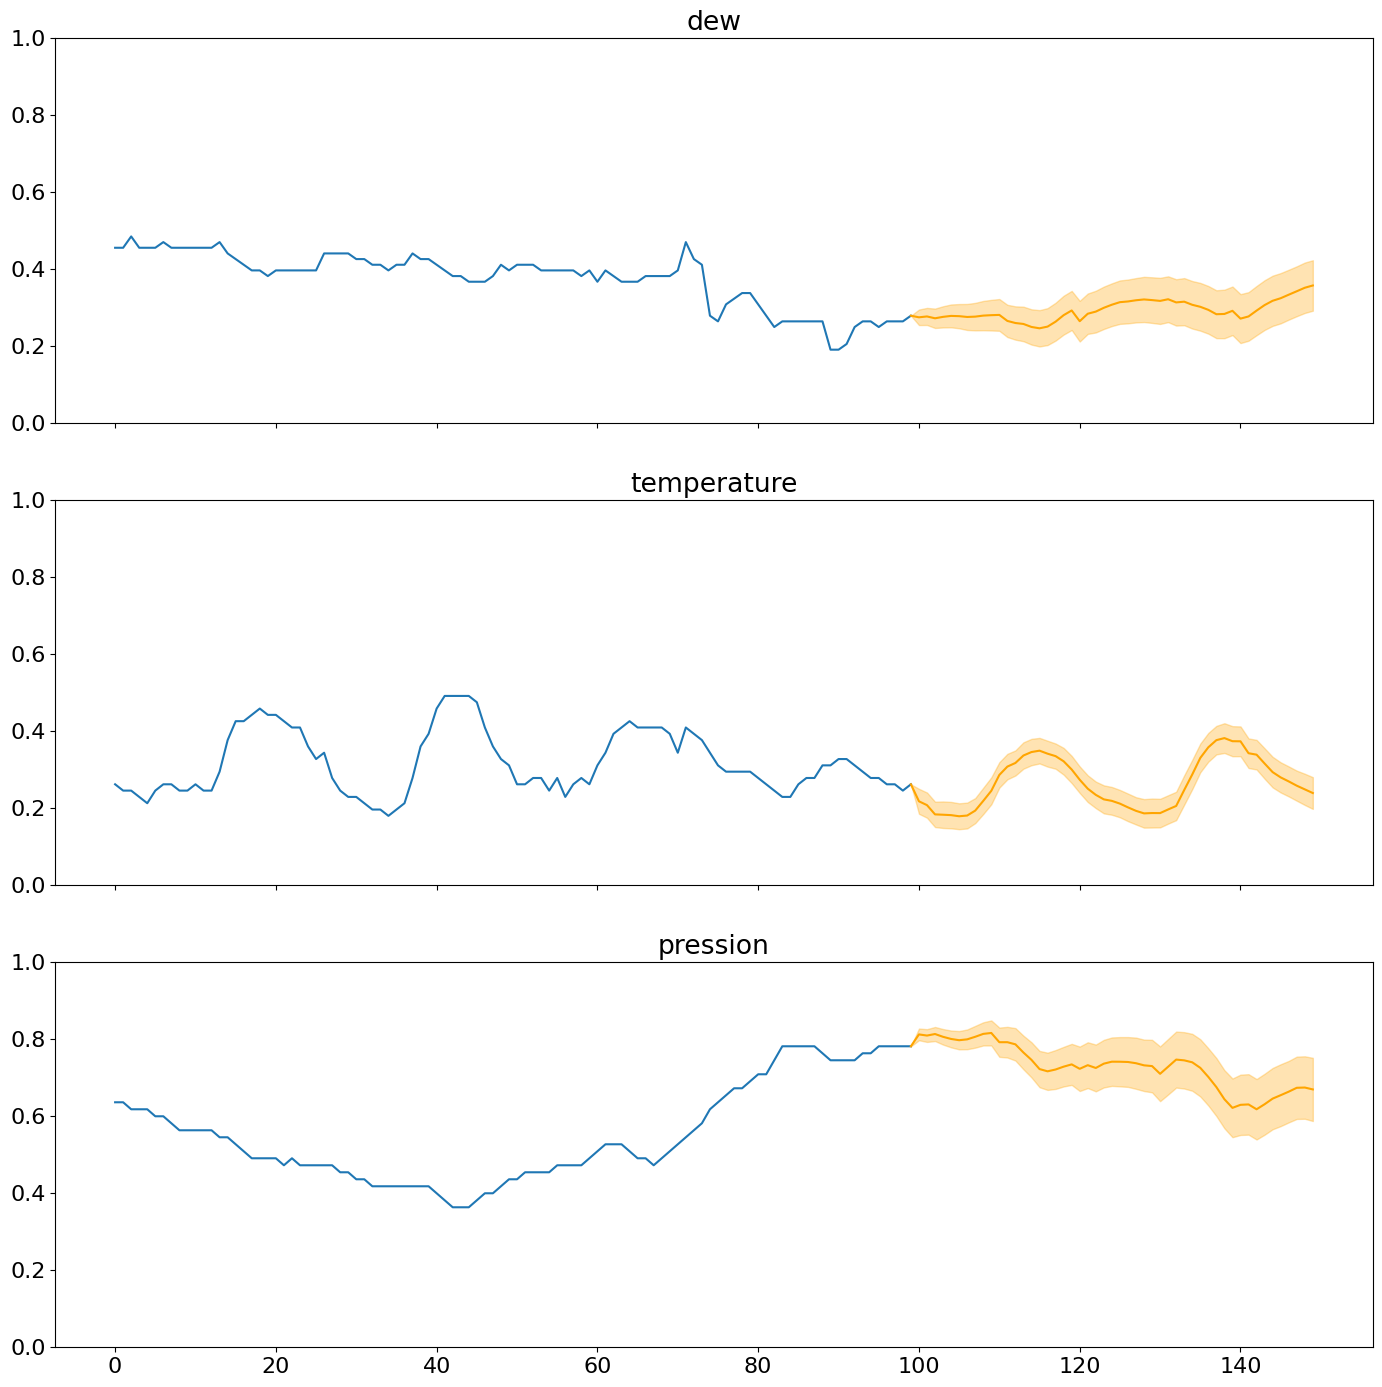

In [45]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i])-1, len(future[0,:,i])+telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i])-1, len(future[0,:,i])+telescope),
        reg_future[0,:,i]+maes[:,i],
        reg_future[0,:,i]-maes[:,i],
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

Try realising new architectures with recurrent and convolutional blocks, perhaps inspired by the CNNs seen in previous lessons. And remember: Attention may be all you need, semicit.

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*